## Project: Vehicle Detection
------------------------------------

In [1]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
# Divide up into cars and notcars
cars = glob.glob('dataset/vehicles/**/*.png')
notcars = glob.glob('dataset/non-vehicles/**/*.png')

# generate 10 random car and non-car images
car_inds = random.sample(range(0, len(cars)-1), 10)
notcar_inds = random.sample(range(0, len(notcars)-1), 10)


In [3]:
# function to read image in rgb format, video frame is by-default in rgb format
def read_image(file):
    # reads image in BGR format
    image = cv2.imread(file)
    # convert to RGB and return
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def convert_color(image, cspace):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    
    return feature_image

Total car images :  8792
Total non-car images :  8968


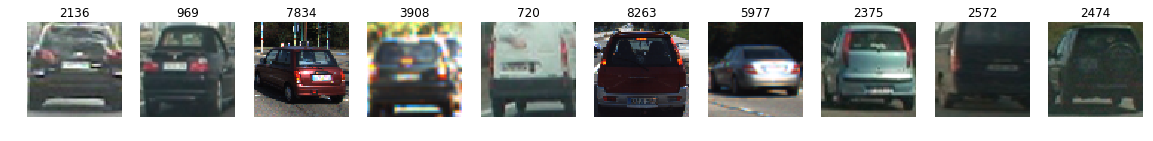

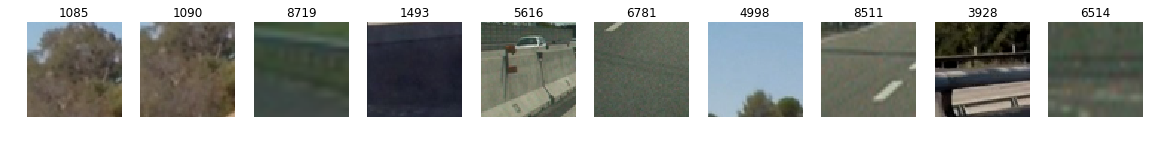

In [5]:
# display dataset samples
print('Total car images : ', len(cars))
print('Total non-car images : ', len(notcars))

# display 10 random car images and non-car images
def show_images(img_list, inds):
    fg, ax = plt.subplots(1, 10, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(10):
        ax[i].axis('off')
        ax[i].imshow(read_image(img_list[inds[i]]))
        ax[i].set_title(inds[i])

show_images(cars, car_inds)
show_images(notcars, notcar_inds)

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

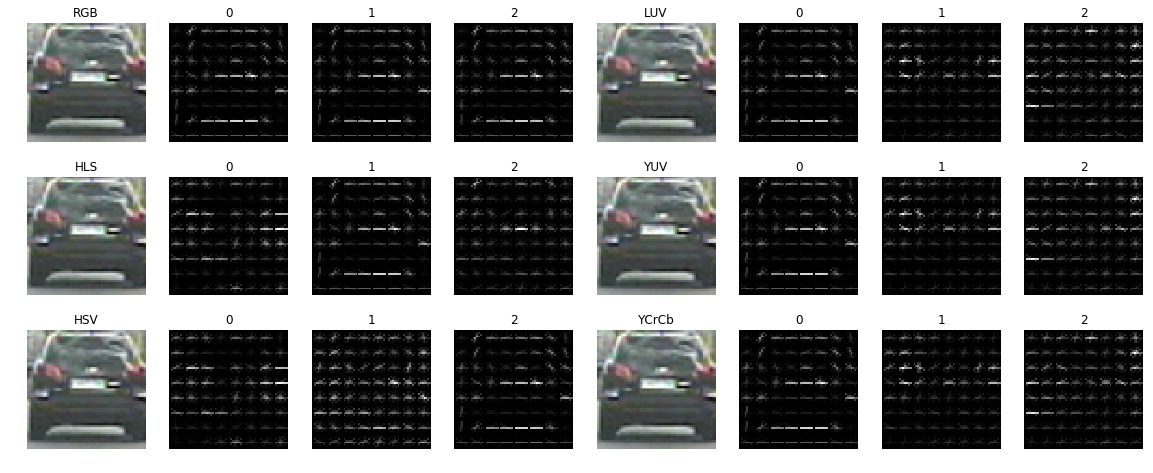

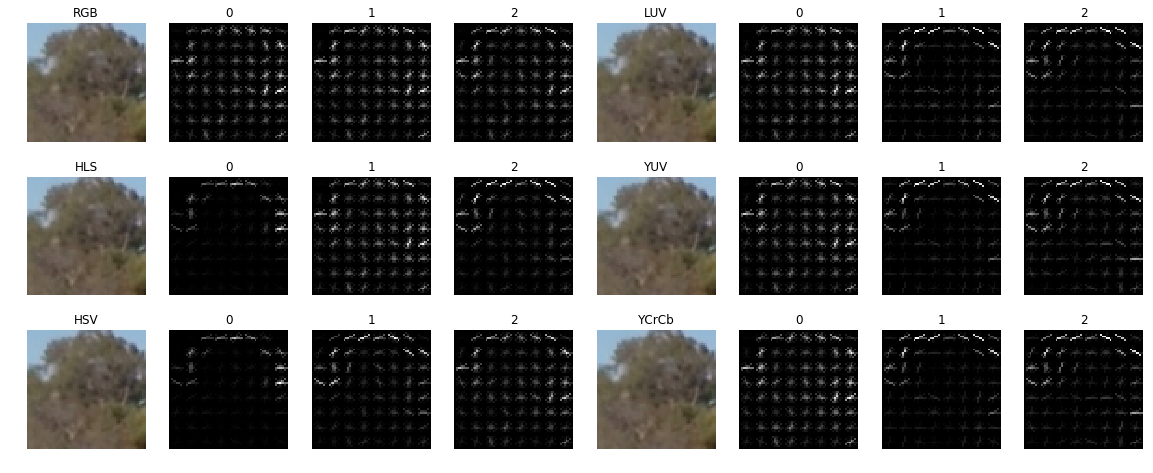

In [7]:
# try HOG for different color spaces
def show_color_hog(file):
    fg, ax = plt.subplots(3, 8, figsize=(20, 8))
    ax = ax.ravel()
    i = 0
    img = read_image(file)
    
    # color spaces to experiment
    cspace = ["RGB", "LUV", "HLS", "YUV", "HSV", "YCrCb"]

    for color_space in cspace:
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(color_space)
        img_out = convert_color(img, color_space)
    
        for j in range(3):
            img_ch = img_out[:,:,j]
            hog_features, hog_image = get_hog_features(img_ch, 9, 8, 2, True)
            
            ax[i+1+j].axis('off')
            ax[i+1+j].imshow(hog_image, cmap='gray')
            ax[i+1+j].set_title(j)
        
        i = i + 4

show_color_hog(cars[car_inds[0]])
show_color_hog(notcars[notcar_inds[0]])

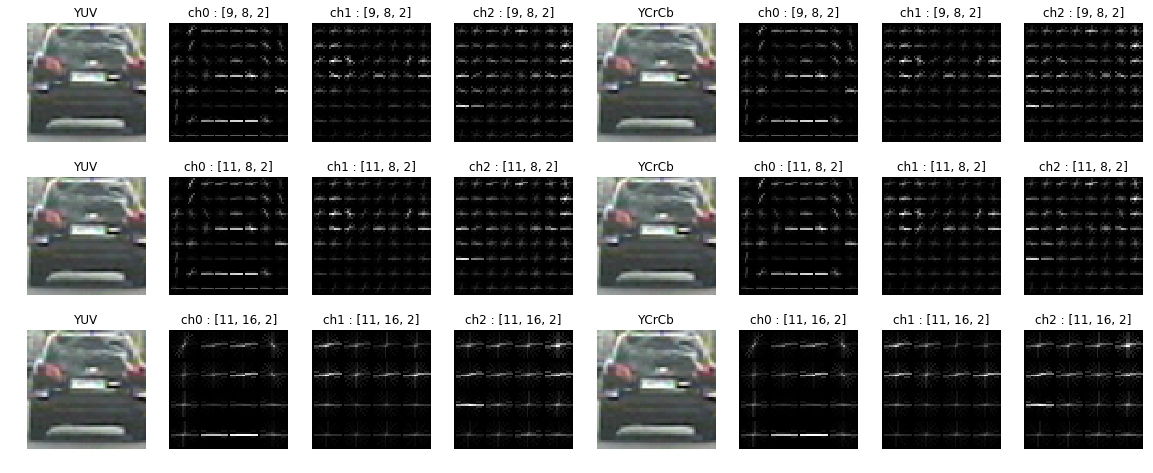

In [8]:
# try HOG with different parameters
def show_hog_params(file):
    fg, ax = plt.subplots(3, 8, figsize=(20, 8))
    ax = ax.ravel()
    i = 0
    img = read_image(file)
    
    hog_vals = [ [9, 8, 2], [11, 8, 2], [11, 16, 2] ]
    cspace   = [ 'YUV', 'YCrCb' ]
    
    for hog_val in hog_vals:
        
        for color in cspace:
            ax[i].axis('off')
            ax[i].imshow(img)
            ax[i].set_title(color)
            img_out = convert_color(img, color)
            
            for j in range(3):
                img_ch = img_out[:,:,j]
                hog_features, hog_image = get_hog_features(img_ch, hog_val[0], hog_val[1], hog_val[2], True)

                ax[i+1+j].axis('off')
                ax[i+1+j].imshow(hog_image, cmap='gray')
                ax[i+1+j].set_title('ch'+str(j)+' : '+str(hog_val))
            i = i + 4

show_hog_params(cars[car_inds[0]])

In [9]:
# combine HOG features of all channels
def extract_hog_features(image, cspace, orient, pix_per_cell, cell_per_block, hog_channel):
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, cspace)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    return hog_features

In [10]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace, orient, pix_per_cell, cell_per_block, hog_channel):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = read_image(file)
        # extract hog features
        hog_features = extract_hog_features(image, cspace, orient, pix_per_cell, cell_per_block, hog_channel)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [11]:
# train the classifier
def train_clf(colorspace, hog_channel, orient, pix_per_cell, cell_per_block):
    ### print('Using:', colorspace, hog_channel, 'channel,', 
    ###      orient,'orientations,',
    ###      pix_per_cell,'pixels per cell and', 
    ###      cell_per_block,'cells per block')
    
    t1=time.time()
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    ### print(round(t2-t1, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    ### print('Train dataset len', len(X_train))
    ### print('Test dataset len', len(X_test))
    ### print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t3=time.time()
    svc.fit(X_train, y_train)
    t4 = time.time()
    
    ### print(round(t4-t3, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    ### print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
    ### print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    # Check the prediction time for a single sample
    #t=time.time()
    #n_predict = 10
    #print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    #print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    #t2 = time.time()
    #print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    print(colorspace, hog_channel, orient, pix_per_cell, cell_per_block, round(t2-t1, 2), 
          len(X_train), len(X_test), len(X_train[0]), round(t4-t3, 2), 
          round(svc.score(X_train, y_train), 4), round(svc.score(X_test, y_test), 4))

    return svc, X_scaler

In [12]:
print('colorspace', 'channel', 'orient', 'pix/cell', 'cell/block', 'T-extract', 
      'N-train', 'N-test', 'N-features', 'T-train', 'Train-%', 'Test-%')
#clf111 = train_clf('YUV',     0, 9, 8, 2)
#clf112 = train_clf('YUV',     1, 9, 8, 2)
#clf113 = train_clf('YUV',     2, 9, 8, 2)
#clf114, X_scaler114 = train_clf('YUV', 'ALL', 9, 8, 2)

#clf121 = train_clf('YUV',     0, 11, 8, 2)
#clf122 = train_clf('YUV',     1, 11, 8, 2)
#clf123 = train_clf('YUV',     2, 11, 8, 2)
#clf124, X_scaler124 = train_clf('YUV', 'ALL', 11, 8, 2)

#clf131 = train_clf('YUV',     0, 11, 16, 2)
#clf132 = train_clf('YUV',     1, 11, 16, 2)
#clf133 = train_clf('YUV',     2, 11, 16, 2)
#clf134, X_scaler134 = train_clf('YUV', 'ALL', 11, 16, 2)

#clf211 = train_clf('YCrCb',     0, 9, 8, 2)
#clf212 = train_clf('YCrCb',     1, 9, 8, 2)
#clf213 = train_clf('YCrCb',     2, 9, 8, 2)
#clf214, X_scaler214 = train_clf('YCrCb', 'ALL', 9, 8, 2)

#clf221 = train_clf('YCrCb',     0, 11, 8, 2)
#clf222 = train_clf('YCrCb',     1, 11, 8, 2)
#clf223 = train_clf('YCrCb',     2, 11, 8, 2)
#clf224, X_scaler224 = train_clf('YCrCb', 'ALL', 11, 8, 2)

#clf231 = train_clf('YCrCb',     0, 11, 16, 2)
#clf232 = train_clf('YCrCb',     1, 11, 16, 2)
#clf233 = train_clf('YCrCb',     2, 11, 16, 2)
clf234, X_scaler234 = train_clf('YCrCb', 'ALL', 11, 16, 2)


colorspace channel orient pix/cell cell/block T-extract N-train N-test N-features T-train Train-% Test-%
YCrCb ALL 11 16 2 62.91 14208 3552 1188 2.09 1.0 0.9873


In [13]:
# sliding window search
def find_cars(img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, disp=False):
    # empty array to save rectangles
    rects = []
    # list of search windows, just for display
    windows = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if disp == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    if disp == True:
        return rects, windows
    return rects

In [14]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

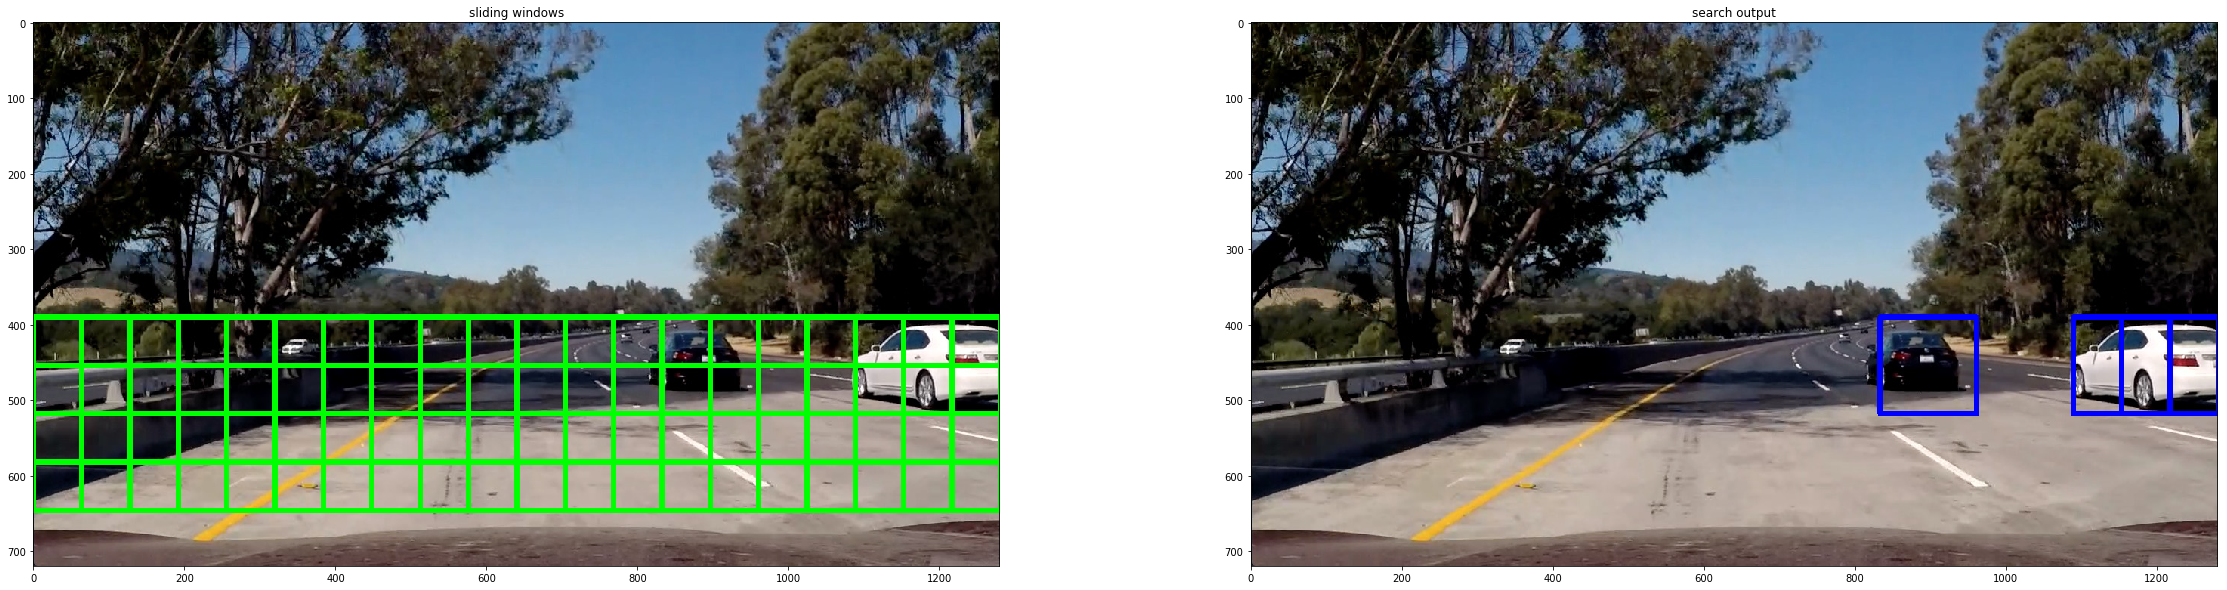

In [15]:
def show_windows(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block):
    rects, windows = find_cars(img, 'YCrCb', ystart, ystop, scale, clf234, X_scaler234, 
                               orient, pix_per_cell, cell_per_block, True)
    rect_out = draw_boxes(img, rects, (0, 0, 255))
    win_out = draw_boxes(img, windows, (0, 255, 0))
    
    fg, ax = plt.subplots(1, 2, figsize=(40, 10))
    ax = ax.ravel()
    
    ax[0].imshow(win_out)
    ax[0].set_title('sliding windows')
    ax[1].imshow(rect_out)
    ax[1].set_title('search output')

show_windows(read_image('test_images/test5.jpg'), 390, 662, 2, 11, 16, 2)

In [16]:
def add_heat(heatmap, bbox_list, weight = 1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += weight

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [17]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [18]:
def draw_labeled_bboxes(labels):
    rects = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        rects.append([bbox[0], bbox[1]])
    # Return the image
    return rects

In [19]:
# create heatmap and threshold
def find_heat(img, box_list, thresh):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,thresh)

    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    boxes = draw_labeled_bboxes(labels)
    
    return boxes, heatmap

In [20]:
# create weighted heatmap
def find_weighted_heat(img, frames):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    for i in range(len(frames)):
        heat = add_heat(heat,frames[i], 1)
        
    heat_max = max(heat.flatten())
    thresh = (heat_max+1)//2
    heat = apply_threshold(heat,thresh)

    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    boxes = draw_labeled_bboxes(labels)

    return boxes, heatmap

In [21]:
# video processing pipeline
frames = []
count = 0

def video_pipeline(img, vis=False):
    global frames
    global count
    box_list = []

    if count % 2 == 0:
        boxes = find_cars(img, 'YCrCb', 390, 662, 3, clf234, X_scaler234, orient=11, pix_per_cell=16, cell_per_block=2)
        box_list = box_list + boxes

        boxes = find_cars(img, 'YCrCb', 390, 662, 2.5, clf234, X_scaler234, orient=11, pix_per_cell=16, cell_per_block=2)
        box_list = box_list + boxes

        boxes = find_cars(img, 'YCrCb', 390, 582, 2, clf234, X_scaler234, orient=11, pix_per_cell=16, cell_per_block=2)
        box_list = box_list + boxes

        boxes = find_cars(img, 'YCrCb', 390, 582, 1.5, clf234, X_scaler234, orient=11, pix_per_cell=16, cell_per_block=2)
        box_list = box_list + boxes

        boxes = find_cars(img, 'YCrCb', 390, 486, 1, clf234, X_scaler234, orient=11, pix_per_cell=16, cell_per_block=2)
        box_list = box_list + boxes
        
        if len(frames) > 0 and len(box_list) == 0:
            frames.remove(frames[0])

    count = count + 1
    out_img = np.copy(img)

    #for box in box_list:
    #    cv2.rectangle(out_img,box[0],box[1],(0,255,0),6) 
    #            
    #boxes, heatmap = find_heat(img, box_list, 1)
    #for box in boxes:
    #    cv2.rectangle(out_img,box[0],box[1],(0,0,255),6) 
    
    if len(box_list) > 0:
        frames.append(box_list)
    if(len(frames) > 10):
        frames.remove(frames[0])
    
    #rects = []
    #for frame in frames:
    #    rects = rects + frame
    
    #for box in rects:
    #    cv2.rectangle(out_img,box[0],box[1],(0,255,0),6) 
    #for box in box_list:
    #    cv2.rectangle(out_img,box[0],box[1],(255,255,0),6)
                
    #n = int(math.sqrt(len(rects)))
    #boxes, heatmap = find_heat(img, rects, n)

    boxes, heatmap = find_weighted_heat(img, frames)
    for box in boxes:
        cv2.rectangle(out_img,box[0],box[1],(0,0,255),6) 
            
    if vis == True:
        return out_img, heatmap
    return out_img

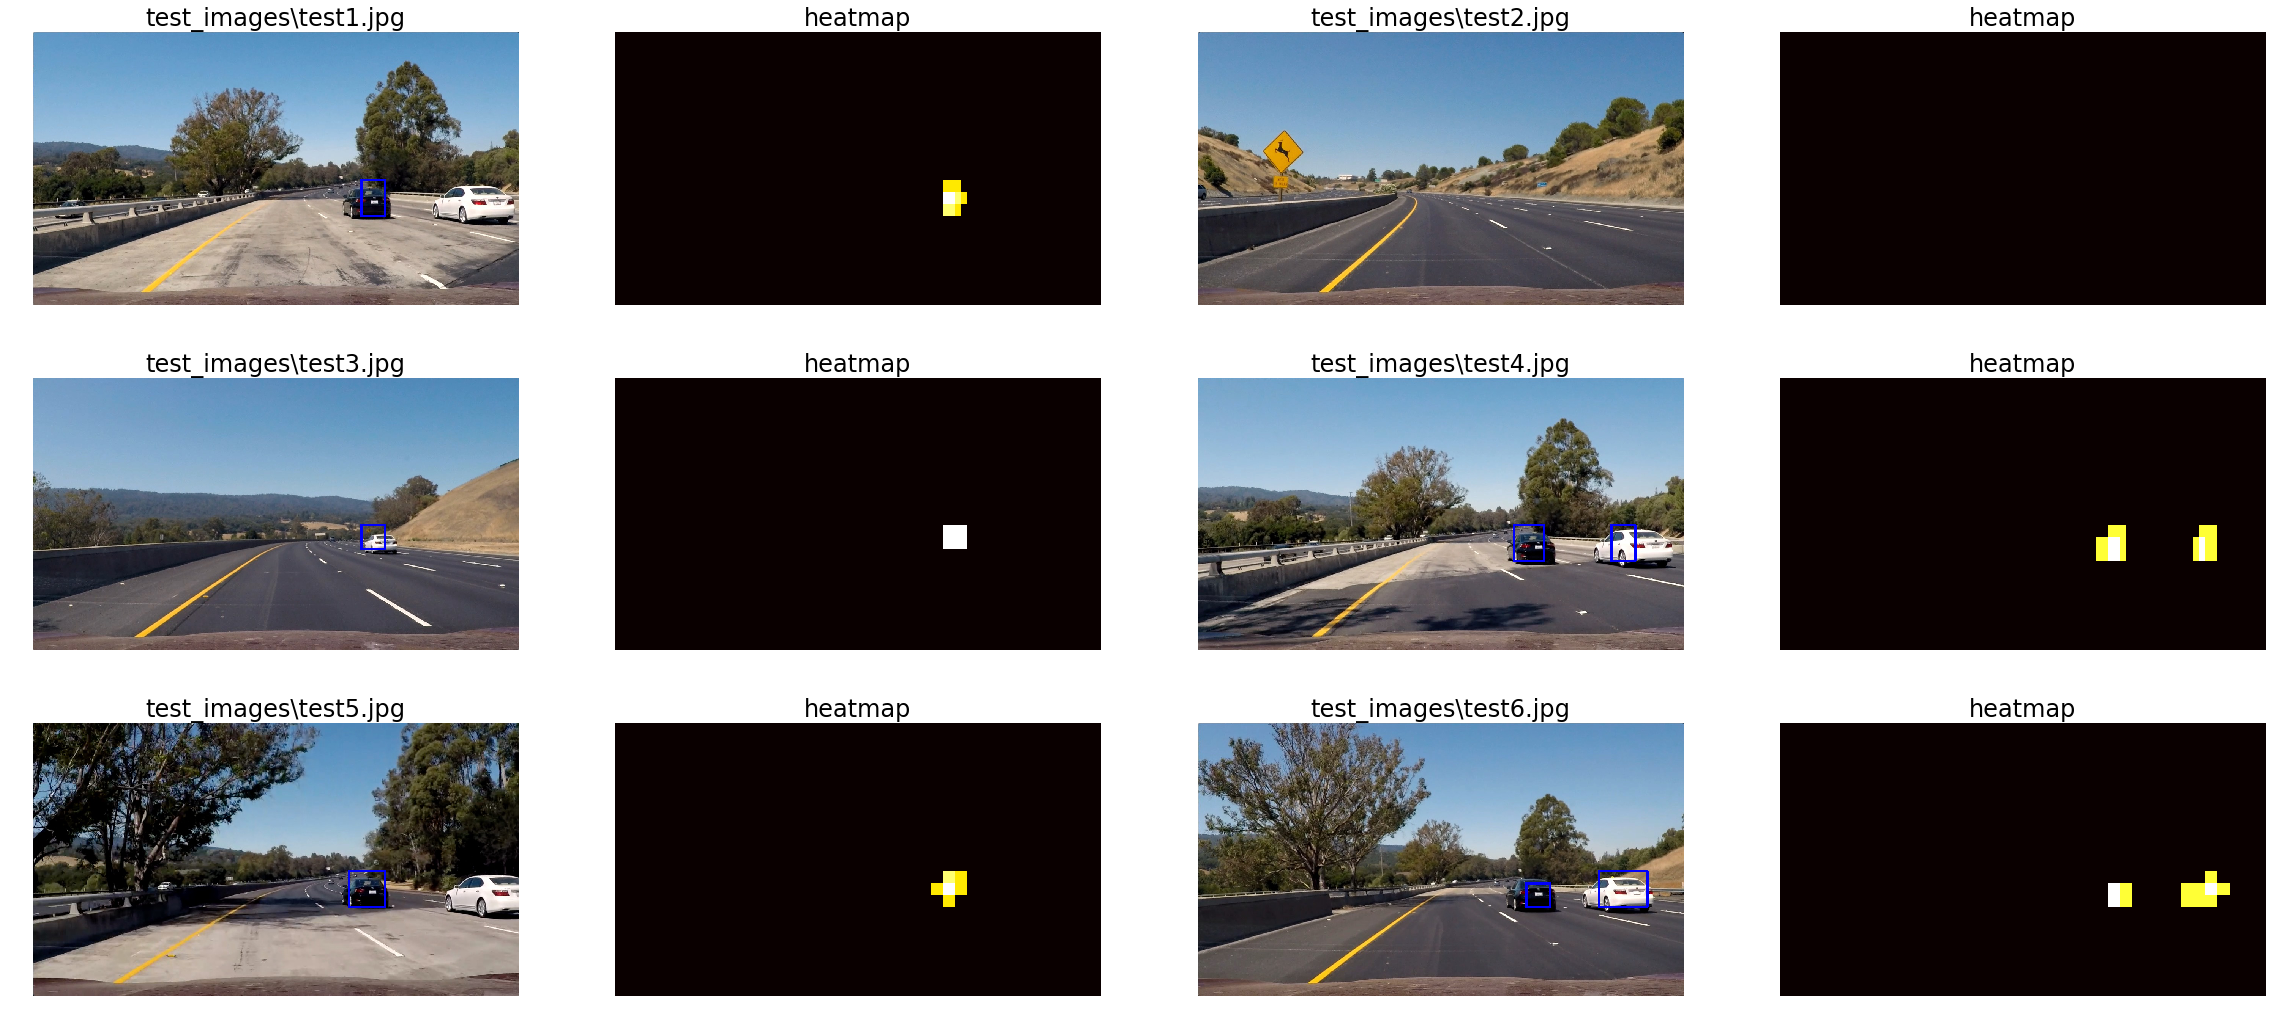

In [22]:
# test video_pipeline and display heatmap
def try_test_images():
    global frames
    global count

    fg, ax = plt.subplots(3, 4, figsize=(40, 18))
    ax = ax.ravel()
    i = 0

    files = glob.glob('test_images/*.jpg')
    for file in files:
        # read image from file
        img = read_image(file)
        while(len(frames) > 0):
            frames.remove(frames[0])
        count = 0
        out_img, heatmap = video_pipeline(img, True)

        # display original image
        ax[i].axis('off')
        ax[i].imshow(out_img)
        ax[i].set_title(file, fontsize=24)
        
        # display transformed image
        ax[i+1].axis('off')
        ax[i+1].imshow(heatmap, cmap='hot')
        ax[i+1].set_title('heatmap', fontsize=24)
        i = i + 2

try_test_images()

In [23]:
while(len(frames) > 0):
    frames.remove(frames[0])
count = 0

from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_output = 'output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('project_video.mp4').subclip(15,35)
clip3 = VideoFileClip('project_video.mp4')
challenge_clip = clip3.fl_image(video_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [13:30<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 13min 31s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))